In [1]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

In [2]:
import tensorflow as tf

In [3]:
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler, TensorDataset
import torch
from tqdm import tqdm, trange

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

import os
import sys

import logging
# Some weird stuff with logging going wrong, so manually disabling the root level. 
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO) 
logging.warning('This is a warning message this should be printed on your console, its level is above the set level')
logging.info('This is an info message it should be printed now!')
logging.debug('This is a debug message which will not be shown, its level is below the set level')

INFO:root:This is an info message it should be printed now!


In [4]:
tokenizer = RobertaTokenizer.from_pretrained("pdelobelle/robBERT-base")
model = RobertaForSequenceClassification.from_pretrained("pdelobelle/robBERT-base")

INFO:transformers.tokenization_utils:Model name 'pdelobelle/robBERT-base' not found in model shortcut name list (roberta-base, roberta-large, roberta-large-mnli, distilroberta-base, roberta-base-openai-detector, roberta-large-openai-detector). Assuming 'pdelobelle/robBERT-base' is a path, a model identifier, or url to a directory containing tokenizer files.
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/vocab.json from cache at /Users/lottewillems/.cache/torch/transformers/dc380186a811c183c3e4c18f48dcb0ccc43b3911653369b7e5ed1b4c6d248931.6a4061e8fc00057d21d80413635a86fdcf55b6e7594ad9e25257d2f99a02f4be
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/pdelobelle/robBERT-base/merges.txt from cache at /Users/lottewillems/.cache/torch/transformers/e5cbecfea4fc4f89fc09c0cb9c97c6093599463446706de81f575ffd1b19deb2.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec37

In [5]:
sys.path.insert(0, os.path.abspath(os.path.join('..')))
from src.train import Train as RobBERTTrainer
from src.textdataset import TextDataset, load_and_cache_examples

## Create a training config

In [6]:
from src.train_config import Config
config = Config()
config.evaluate_dataset = "../data/processed/dbrd/eval"

## Load in the data
We use `load_and_cache_examples` to load in the training data, this will produce a tokenized version with torch tensors.

For the test and evaluation sets, we'll use the following `evaluate` function, since we're in the end interested in a dataframe with all inputs and predictions.

In [85]:
def evaluate(dataset, model):
    df = pd.read_table(dataset + ".labels.txt", header=None, names=['labels'])
    df['sentence'] = pd.read_table(dataset + ".sentences.txt", header=None, names=['sentence'])
    model.eval() # disable dropout etc.
    
    mask_padding_with_zero = True
    block_size = 512
    results = []
    for row in tqdm(df.iterrows(), total=len(df), mininterval=1, position=1, leave=True):
        index = row[0]
        sentence = row[1]['sentence']
        label = row[1]['labels']

        #tokens = roberta.encode(sentence)

        tokenized_text = tokenizer.encode(tokenizer.tokenize(sentence)[- block_size + 3 : -1])

        input_mask = [1 if mask_padding_with_zero else 0] * len(tokenized_text)

        pad_token = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        while len(tokenized_text) < block_size:
            tokenized_text.append(pad_token)
            input_mask.append(0 if mask_padding_with_zero else 1)
            #segment_ids.append(pad_token_segment_id)
            #p_mask.append(1)

        #self.examples.append([tokenizer.build_inputs_with_special_tokens(tokenized_text[0 : block_size]), [0], [0]])
        batch = tuple(torch.tensor(t).to(torch.device("cpu")) for t in [tokenized_text[0 : block_size - 3], input_mask[0 : block_size- 3], [0], [1] if label else [0]])
        inputs = {"input_ids": batch[0].unsqueeze(0), "attention_mask": batch[1].unsqueeze(0), "labels": batch[3].unsqueeze(0)}
        with torch.no_grad():
            outputs = model(**inputs)

            results.append({"sentence": sentence, "true": label, "predicted": outputs[1][0].argmax().item()})

    model.train() # make sure the model is back in training mode
    return results

In [63]:
train_dataset = load_and_cache_examples("roberta", tokenizer, "../data/processed/dbrd/train")

INFO:src.textdataset:Creating features from dataset file at ../data/processed/dbrd
INFO:src.textdataset:Saving features into cached file ../data/processed/dbrd/roberta_cached_lm_512_train


In [9]:
model.train()
logging.info("Put RobBERT in training mode")

INFO:root:Put RobBERT in training mode


In [76]:
from transformers import AdamW
import torch
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
import os
from tqdm import tqdm, trange
import pandas as pd
from pycm import ConfusionMatrix

try:
    from torch.utils.tensorboard import SummaryWriter
except ImportError:
    from tensorboardX import SummaryWriter

import json

from transformers import get_linear_schedule_with_warmup

class Train:
    def train(args, train_dataset, model, tokenizer, evaluate_fn=None):
        """ Train the model """
        logging.basicConfig(level=logging.INFO)
        model.train()

        if args.local_rank in [-1, 0]:
            tb_writer = SummaryWriter()
            
        # My device does not have GPU so args.device = cpu
        args.device = "cpu"
        args.n_gpu = torch.cuda.device_count() # 0
        args.per_gpu_train_batch_size = 2
        args.gradient_accumulation_steps = 4
        
        args.train_batch_size = args.per_gpu_train_batch_size * max(1, args.n_gpu)
        train_sampler = RandomSampler(train_dataset) if args.local_rank == -1 else DistributedSampler(train_dataset)
        train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
        
        args.output_dir = "./dbrd_model2/"
        args.model_name_or_path = "./dbrd_model2/"
    
        if args.max_steps > 0:
            t_total = args.max_steps
            args.num_train_epochs = 2 ## args.max_steps // (len(train_dataset) // args.gradient_accumulation_steps) + 1
        else:
            t_total = len(train_dataset) // args.gradient_accumulation_steps * args.num_train_epochs

        # Prepare optimizer and schedule (linear warmup and decay)
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": args.weight_decay,
            },
            {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
        ]

        optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=args.warmup_steps, num_training_steps=t_total
        )

        # Check if saved optimizer or scheduler states exist
        if os.path.isfile(os.path.join(args.model_name_or_path, "optimizer.pt")) and os.path.isfile(
            os.path.join(args.model_name_or_path, "scheduler.pt")
        ):
            # Load in optimizer and scheduler states
            optimizer.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "optimizer.pt")))
            scheduler.load_state_dict(torch.load(os.path.join(args.model_name_or_path, "scheduler.pt")))

        # device = cpu, I don't have a GPU
        model.to(args.device)

        # Train!
        logging.info("***** Running training *****")
        logging.info("  Num examples = %d", len(train_dataset))
        logging.info("  Num Epochs = %d", args.num_train_epochs)
        logging.info("  Instantaneous batch size per GPU = %d", args.per_gpu_train_batch_size)
        logging.info(
            "  Total train batch size (w. parallel, distributed & accumulation) = %d",
            args.train_batch_size
            * args.gradient_accumulation_steps
            * (torch.distributed.get_world_size() if args.local_rank != -1 else 1),
        )
        logging.info("  Gradient Accumulation steps = %d", args.gradient_accumulation_steps)
        logging.info("  Total optimization steps = %d", t_total)

        global_step = 0
        epochs_trained = 0
        steps_trained_in_current_epoch = 0
        
        # Check if continuing training from a checkpoint
#         if os.path.exists(args.model_name_or_path):
#             # set global_step to gobal_step of last saved checkpoint from model path
#             global_step = 0 # from global_step.txt
#             epochs_trained = global_step // (len(train_dataset) // args.gradient_accumulation_steps)
#             steps_trained_in_current_epoch = global_step % (len(train_dataset) // args.gradient_accumulation_steps)

#             logging.info("  Continuing training from checkpoint, will skip to saved global_step")
#             logging.info("  Continuing training from epoch %d", epochs_trained)
#             logging.info("  Continuing training from global step %d", global_step)
#             logging.info("  Will skip the first %d steps in the first epoch", steps_trained_in_current_epoch)

        tr_loss, logging_loss = 0.0, 0.0
        model.zero_grad()
        train_iterator = trange(
            epochs_trained, int(args.num_train_epochs), desc="Epoch", disable=args.local_rank not in [-1, 0],
        )
        # set_seed(args)  # Added here for reproductibility
        for _ in train_iterator:
            epoch_iterator = tqdm(train_dataloader, desc="Iteration", disable=args.local_rank not in [-1, 0], position=0, leave=True)
            for step, batch in enumerate(epoch_iterator):

                # Skip past any already trained steps if resuming training
                if steps_trained_in_current_epoch > 0:
                    steps_trained_in_current_epoch -= 1
                    continue

                model.train()
                batch = tuple(t.to(args.device) for t in batch)
                inputs = {"input_ids": batch[0], "attention_mask": batch[1], "labels": batch[3]}
                if args.model_type != "distilbert":
                    inputs["token_type_ids"] = (
                        batch[2] if args.model_type in ["bert", "xlnet", "albert"] else None
                    )  # XLM, DistilBERT, RoBERTa, and XLM-RoBERTa don't use segment_ids
                outputs = model(**inputs)
                loss = outputs[0]  # model outputs are always tuple in transformers (see doc)
                
                if args.gradient_accumulation_steps > 1:
                    loss = loss / args.gradient_accumulation_steps
                
                loss.backward()

                tr_loss += loss.item()
                
                if (step + 1) % args.gradient_accumulation_steps == 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                    optimizer.step()
                    scheduler.step()  # Update learning rate schedule
                    model.zero_grad()
                    global_step += 1
                    
                    if global_step % 20 == 0:
                        output_dir = args.output_dir #os.path.join(args.output_dir, "checkpoint-{}".format(global_step))
                        file_global_step = open("global_step.txt","w") # write mode 
                        file_global_step.write(str(global_step))
                        file_global_step.close()
                        model_to_save = (model.module if hasattr(model, "module") else model)
                        model_to_save.save_pretrained(output_dir)
                        tokenizer.save_pretrained(output_dir)

                        torch.save(args, os.path.join(output_dir, "training_args.bin"))
                        logging.info("Saving model checkpoint to %s", output_dir)

                        torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                        torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))
                        logging.info("Saving optimizer and scheduler states to %s", output_dir)

                    if args.local_rank in [-1, 0] and args.logging_steps > 0 and global_step % args.logging_steps == 0:
                        logs = {}
                        if (
                            args.local_rank == -1 and args.evaluate_during_training
                        ):  # Only evaluate when single GPU otherwise metrics may not average well
                            # I don't have a GPU.. 
                            results = evaluate(args, model, tokenizer)
                            for key, value in results.items():
                                eval_key = "eval_{}".format(key)
                                logs[eval_key] = value

                        loss_scalar = (tr_loss - logging_loss) / args.logging_steps
                        learning_rate_scalar = scheduler.get_lr()[0]
                        logs["learning_rate"] = learning_rate_scalar
                        logs["loss"] = loss_scalar
                        logging_loss = tr_loss

                        for key, value in logs.items():
                            tb_writer.add_scalar(key, value, global_step)
                        epoch_iterator.set_postfix({**logs, **{"step": global_step}})
                    
                if args.max_steps > 0 and global_step > args.max_steps:
                    epoch_iterator.close()
                    break
            if args.max_steps > 0 and global_step > args.max_steps:
                train_iterator.close()
                break

            if evaluate_fn is not None:
                results = pd.DataFrame(evaluate_fn(args.evaluate_dataset, model))
                cm = ConfusionMatrix(actual_vector=results['true'].values, predict_vector=results['predicted'].values)
                logs = {}
                logs["eval_f1_macro"] = cm.F1_Macro
                logs["eval_acc_macro"] = cm.ACC_Macro
                logs["eval_acc_overall"] = cm.Overall_ACC
                logging.info("Results on eval: {}".format(logs))


        if args.local_rank in [-1, 0]:
            tb_writer.close()
        
        return global_step, tr_loss / global_step, optimizer


In [77]:
globalstep, trainloss, optimizer = Train.train(config, train_dataset, model, tokenizer, evaluate)

INFO:root:***** Running training *****
INFO:root:  Num examples = 10029
INFO:root:  Num Epochs = 2
INFO:root:  Instantaneous batch size per GPU = 2
INFO:root:  Total train batch size (w. parallel, distributed & accumulation) = 8
INFO:root:  Gradient Accumulation steps = 4
INFO:root:  Total optimization steps = 2000







Iteration:   0%|          | 3/5015 [00:23<11:25:47,  8.21s/it]/Users/lottewillems/opt/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "
Iteration:   2%|▏         | 79/5015 [09:47<9:22:30,  6.84s/it, learning_rate=6.74e-6, loss=0.00156, step=19]  INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:roo

INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  32%|███▏      | 1599/5015 [3:12:56<6:30:32,  6.86s/it, learning_rate=0, loss=0.0041, step=399]  INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  33%|███▎      | 1679/5015 [3:22:32<6:22:57,  6.89s/it, learning_rate=0, loss=1.65, step=419]    INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  35%|███▌      | 1759/5015 [3:32:06<6:13:31,  6.88s/it, learning_rate

INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  97%|█████████▋| 4879/5015 [9:46:30<16:03,  7.08s/it, learning_rate=0, loss=0.504, step=1219]   INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  99%|█████████▉| 4959/5015 [9:56:04<06:25,  6.88s/it, learning_rate=0, loss=0.012, step=1239]   INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_mo

INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  12%|█▏        | 587/5015 [1:11:07<8:36:34,  7.00s/it, learning_rate=0, loss=0.000931, step=1399]INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  13%|█▎        | 667/5015 [1:20:40<8:18:55,  6.88s/it, learning_rate=0, loss=0.00108, step=1419] INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model2/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model2/pytorch_model.bin
INFO:root:Saving model checkpoint to ./dbrd_model2/
INFO:root:Saving optimizer and scheduler states to ./dbrd_model2/
Iteration:  15%|█▍        | 747/5015 [1:30:14<8:06:04,  6.83s/it, learning_rate=

## Evaluate our trained model

In [86]:
model.eval()
logging.info("putting model in eval mode")

INFO:root:putting model in eval mode


In [87]:
results = pd.DataFrame(evaluate("../data/processed/dbrd/test", model))


 14%|█▎        | 303/2224 [05:20<33:27,  1.04s/it]


 27%|██▋       | 605/2224 [10:38<28:37,  1.06s/it]


 41%|████      | 907/2224 [16:01<23:19,  1.06s/it]


 54%|█████▍    | 1205/2224 [21:17<18:11,  1.07s/it]


 67%|██████▋   | 1501/2224 [26:28<12:39,  1.05s/it]


 81%|████████  | 1797/2224 [31:38<07:32,  1.06s/it]


 94%|█████████▍| 2095/2224 [36:47<02:15,  1.05s/it]


100%|██████████| 2224/2224 [39:02<00:00,  1.06s/it]

100%|██████████| 2224/2224 [39:02<00:00,  1.05s/it]


In [88]:
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0, aspect="equal")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.ylim(len(tick_marks) - 0.5, -0.5)
    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1012  100]
 [  89 1023]]


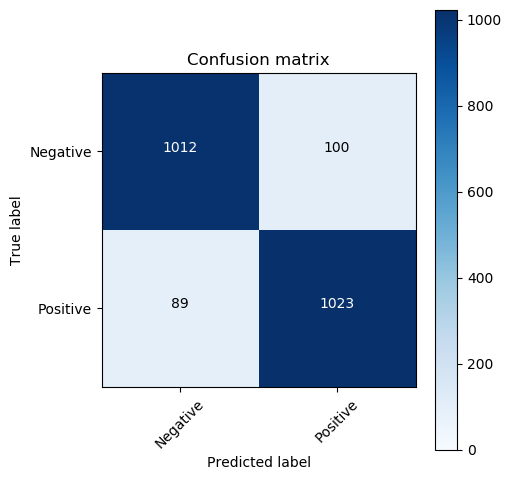

In [89]:
cnf_matrix = confusion_matrix(results['true'], results['predicted'] ) # index to evaluate partial runs

np.set_printoptions(precision=2)

title="Confusion matrix"

# Plot normalized confusion matrix
fig = plt.figure(figsize=(5,5), dpi=100)
#fig.set_size_inches(6,6)

plot_confusion_matrix(cnf_matrix, classes=["Negative", "Positive"],normalize=False, 
                      title=title, cmap=plt.cm.Blues)


In [90]:
cm = ConfusionMatrix(actual_vector=results['true'].values, predict_vector=results['predicted'].values )

In [91]:
cm.stat()

Overall Statistics : 

95% CI                                                            (0.90343,0.92661)
ACC Macro                                                         0.91502
ARI                                                               0.68882
AUNP                                                              0.91502
AUNU                                                              0.91502
Bennett S                                                         0.83004
CBA                                                               0.91051
CSI                                                               0.83008
Chi-Squared                                                       1532.39635
Chi-Squared DF                                                    1
Conditional Entropy                                               0.41927
Cramer V                                                          0.83008
Cross Entropy                                                     1.00007
F1 Macro

## Saving the model

In [118]:
from transformers import WEIGHTS_NAME, CONFIG_NAME

output_dir = "./dbrd_model/"
model_to_save = model.module if hasattr(model, 'module') else model

# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(output_dir, WEIGHTS_NAME)

output_config_file = os.path.join(output_dir, CONFIG_NAME)

torch.save(model.state_dict(), "./dbrd_model/model.pt")
model_to_save.config.to_json_file(output_config_file)
model_to_save.config.to_json_file(output_model_file)
tokenizer.save_vocabulary(output_dir)

('./dbrd_model/vocab.json', './dbrd_model/merges.txt')

In [25]:
## Save finetuned model
model.save_pretrained("./dbrd_model/")

INFO:transformers.configuration_utils:Configuration saved in ./dbrd_model/config.json
INFO:transformers.modeling_utils:Model weights saved in ./dbrd_model/pytorch_model.bin


In [33]:
## Load finetuned model
model = model.from_pretrained("./dbrd_model/")

INFO:transformers.configuration_utils:loading configuration file ./dbrd_model/config.json
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "_num_labels": 2,
  "architectures": [
    "RobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "do_sample": false,
  "early_stopping": false,
  "eos_token_id": 2,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-05,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 514,
  "min_length": 0,
  "model_type": "roberta",
  "no_repeat_ngram_size": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_return_sequences": 1,
  "output_att

In [34]:
def predict(dataset, model):
    results = []
    for item in dataset:
        tokenized_text = tokenizer.encode(tokenizer.tokenize(item))
        
        pad_token = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
        
        input_mask = [0] * len(tokenized_text)
        
        batch = tuple(torch.tensor(t).to(torch.device("cpu")) for t in [tokenized_text[0 : len(tokenized_text)], input_mask[0 : len(tokenized_text)], [0], [1]])
        # Manually set a label but not use it, just to not break the code.
        
        inputs = {"input_ids": batch[0].unsqueeze(0), "attention_mask": batch[1].unsqueeze(0), "labels": batch[3].unsqueeze(0)}
        outputs = model(**inputs)

        results.append({"text": item, "predicted": outputs[1][0].argmax().item()})

    model.train() # make sure the model is back in training mode
    return results #, outputs

In [35]:
texts = [("Mijn vrouw vond het een prachtig boek, ik niet"), ("Mijn man vond het een prachtig boek, ik niet"), ("Mijn partner vond het een prachtig boek, ik niet")]
resulttest1 = pd.DataFrame(predict(texts, model))

In [36]:
print(resulttest1)

## 0 is negative, 1 is positive

                                               text  predicted
0    Mijn vrouw vond het een prachtig boek, ik niet          1
1      Mijn man vond het een prachtig boek, ik niet          1
2  Mijn partner vond het een prachtig boek, ik niet          1


In [37]:
texts = [("Mijn vrouw vond het geen mooi boek, ik wel"), ("Mijn man vond het geen mooi boek, ik wel")]
resulttest2 = pd.DataFrame(predict(texts, model))

In [38]:
print(resulttest2)

                                         text  predicted
0  Mijn vrouw vond het geen mooi boek, ik wel          0
1    Mijn man vond het geen mooi boek, ik wel          0


In [60]:
text = "De tijden dat boeken lezen leuk was zijn er niet meer."

In [61]:
textsss = [(text)]
result_textsss = pd.DataFrame(predict(textsss, model))